In [1]:
print("test2")

test2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity
import random

In [3]:
# Dataset for Gaze Triplets
class TripletGazeDataset(Dataset):
    def __init__(self, csv_file, sequence_length=10):
        self.data = pd.read_csv(csv_file)
        self.sequence_length = sequence_length
        self.data['Name'] = self.data['Name'].astype('category')
        self.data['Label'] = self.data['Name'].cat.codes
        self.labels = self.data['Label'].unique()
        
        # Group data by labels for easier access to positive and negative examples
        self.groups = {label: group[['X', 'Y']].values for label, group in self.data.groupby('Label')}
        
    def __len__(self):
        return len(self.data) // self.sequence_length  # Approximate number of triplets

    def __getitem__(self, idx):
        anchor_label = random.choice(self.labels)
        positive_label = anchor_label
        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        
        anchor_sequence = self._sample_sequence(anchor_label)
        positive_sequence = self._sample_sequence(positive_label)
        negative_sequence = self._sample_sequence(negative_label)

        anchor = torch.tensor(anchor_sequence, dtype=torch.float32)
        positive = torch.tensor(positive_sequence, dtype=torch.float32)
        negative = torch.tensor(negative_sequence, dtype=torch.float32)
        
        return anchor, positive, negative

    def _sample_sequence(self, label):
        coords = self.groups[label]
        start_idx = random.randint(0, len(coords) - self.sequence_length)
        return coords[start_idx:start_idx + self.sequence_length]

In [ ]:
## LSTM Model
class GazeLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, num_classes=2):
        super(GazeLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(x.device)
        c0 = torch.zeros(2, x.size(0), 64).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  ## Using the last LSTM output
        return out

In [ ]:
# Model for generating embeddings
class GazeEmbeddingModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, embedding_size=128, num_layers=2):
        super(GazeEmbeddingModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, embedding_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(x.device)
        c0 = torch.zeros(2, x.size(0), 64).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        embedding = self.fc(out[:, -1, :])  # Use last hidden state as embedding
        return embedding

In [6]:
# Triplet Loss Function
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.norm(anchor - positive, p=2, dim=1)
        neg_dist = torch.norm(anchor - negative, p=2, dim=1)
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        return loss.mean()

In [37]:
# Training function for embedding model with Early Stopping
def train_embedding_model(model, train_loader, test_loader, optimizer, num_epochs=10, early_stop = False, patience=5):
    model.train()  # Ensure model is in training mode at the start
    criterion = TripletLoss()  # Assuming you have TripletLoss implemented
    loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    best_test_loss = np.inf  # Best test loss to track improvement
    epochs_without_improvement = 0  # Track how many epochs we've seen without improvement in validation loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct_train = 0
        total_train_samples = 0

        # Training loop
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Get embeddings
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)

            # Calculate triplet loss
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            running_loss += loss.item()

            # Calculate accuracy based on anchor-positive and anchor-negative distances
            pos_dist = torch.norm(anchor_embedding - positive_embedding, p=2, dim=1)
            neg_dist = torch.norm(anchor_embedding - negative_embedding, p=2, dim=1)
            running_correct_train += torch.sum(pos_dist < neg_dist).item()  # Correct if anchor-positive < anchor-negative
            total_train_samples += anchor.size(0)

        # Calculate epoch metrics for training
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = running_correct_train / total_train_samples
        loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")

        # Evaluate on test data after each epoch
        test_loss, test_accuracy = evaluate_embedding_model(model, test_loader)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Early stopping check: if the test loss doesn't improve for 'patience' epochs, stop training
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if early_stop and epochs_without_improvement >= patience:
            print(f"Early stopping triggered. No improvement in test loss for {patience} epochs.")
            break

    # Plot training and testing loss and accuracy curves
    plot_loss_accuracy_curves(loss_history, test_loss_history, train_accuracy_history, test_accuracy_history)


# Evaluation function for test data
def evaluate_embedding_model(model, data_loader):
    model.eval()  # Ensure model is in evaluation mode during evaluation
    criterion = TripletLoss()  # Assuming you have TripletLoss implemented
    running_loss = 0.0
    running_correct_test = 0
    total_test_samples = 0

    with torch.no_grad():  # No gradients are computed during evaluation
        for anchor, positive, negative in data_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Get embeddings
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)

            # Calculate triplet loss
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            running_loss += loss.item()

            # Calculate accuracy based on anchor-positive and anchor-negative distances
            pos_dist = torch.norm(anchor_embedding - positive_embedding, p=2, dim=1)
            neg_dist = torch.norm(anchor_embedding - negative_embedding, p=2, dim=1)
            running_correct_test += torch.sum(pos_dist < neg_dist).item()  # Correct if anchor-positive < anchor-negative
            total_test_samples += anchor.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(data_loader)
    avg_accuracy = running_correct_test / total_test_samples
    return avg_loss, avg_accuracy


# Function to plot loss and accuracy curves
def plot_loss_accuracy_curves(train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history):
    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 6))

    # Subplot for Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Testing Loss Curves")
    plt.legend()

    # Subplot for Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, label="Train Accuracy")
    plt.plot(test_accuracy_history, label="Test Accuracy", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Testing Accuracy Curves")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [38]:
# Enrollment and Authentication functions
stored_embeddings = {}

In [39]:
def enroll_new_user(user_id, gaze_sequence, stored_embeddings):
    """Enroll a new user by saving their gaze embedding."""
    gaze_sequence = torch.tensor(gaze_sequence, dtype=torch.float32).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        embedding = model(gaze_sequence)
        stored_embeddings[user_id] = embedding
    print(f"New user {user_id} enrolled successfully.")

In [40]:
def authenticate_user(gaze_sequence, stored_embeddings, threshold=0.8):
    """Authenticate a user based on similarity to stored embeddings."""
    gaze_sequence = torch.tensor(gaze_sequence, dtype=torch.float32).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        embedding = model(gaze_sequence)
        for user_id, user_embedding in stored_embeddings.items():
            similarity = cosine_similarity(embedding, user_embedding)
            if similarity >= threshold:
                return True, f"User authenticated as user ID {user_id}"
    return False, "Access denied: No matching user found."

# Training setup

In [41]:
# Set up and train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sequence_length = 10
csv_file = '../data/point_data/gaze_data_combined.csv'

In [42]:
# Prepare Data
train_dataset = TripletGazeDataset(csv_file, sequence_length=sequence_length)
test_dataset = TripletGazeDataset(csv_file, sequence_length=sequence_length)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [43]:
# Initialize model, optimizer
model = GazeEmbeddingModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Model

Epoch [1/100], Training Loss: 0.1190, Training Accuracy: 0.9672
Test Loss: 0.1204, Test Accuracy: 0.9672
Epoch [2/100], Training Loss: 0.1767, Training Accuracy: 0.9672
Test Loss: 0.0248, Test Accuracy: 0.9836
Epoch [3/100], Training Loss: 0.1866, Training Accuracy: 0.9508
Test Loss: 0.1355, Test Accuracy: 0.9672
Epoch [4/100], Training Loss: 0.1446, Training Accuracy: 0.9344
Test Loss: 0.1249, Test Accuracy: 0.9672
Epoch [5/100], Training Loss: 0.2069, Training Accuracy: 0.9344
Test Loss: 0.0310, Test Accuracy: 0.9836
Epoch [6/100], Training Loss: 0.0889, Training Accuracy: 0.9836
Test Loss: 0.1289, Test Accuracy: 0.9344
Epoch [7/100], Training Loss: 0.1152, Training Accuracy: 0.9508
Test Loss: 0.0613, Test Accuracy: 0.9836
Epoch [8/100], Training Loss: 0.1023, Training Accuracy: 0.9672
Test Loss: 0.1327, Test Accuracy: 0.9508
Epoch [9/100], Training Loss: 0.1179, Training Accuracy: 0.9672
Test Loss: 0.0217, Test Accuracy: 1.0000
Epoch [10/100], Training Loss: 0.1504, Training Accurac

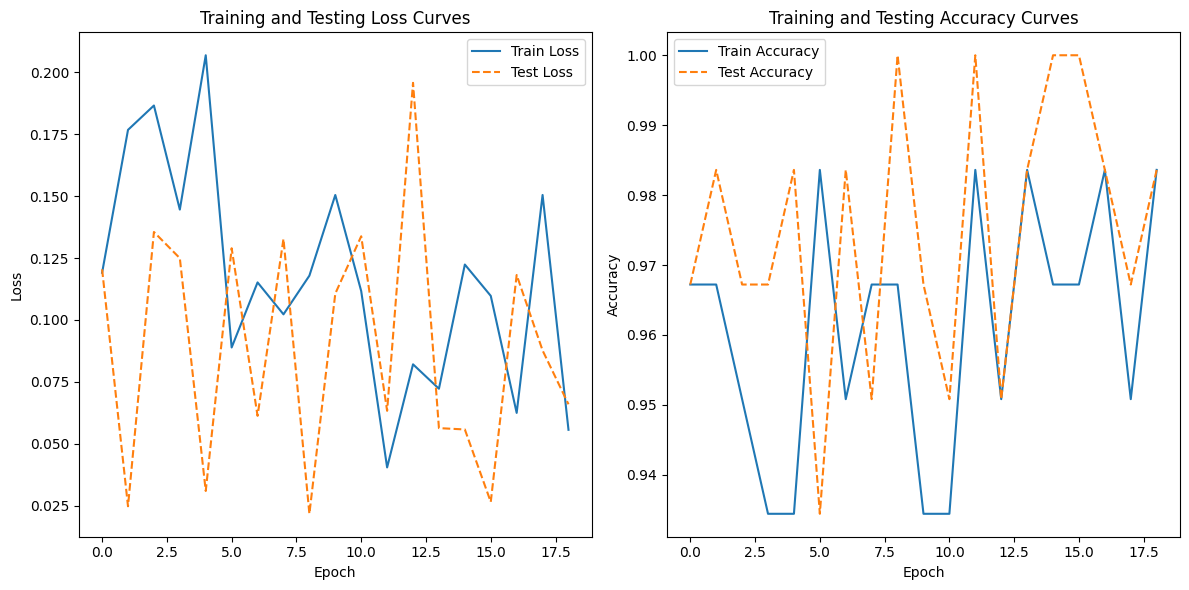

In [45]:
train_embedding_model(model, train_loader, test_loader, optimizer, num_epochs=100, early_stop=True, patience=10)

In [47]:
# Save model
torch.save(model.state_dict(), '../models/gaze_embedding_model.pth')
print("Model saved as gaze_embedding_model.pth")

Model saved as gaze_embedding_model.pth


# Inference example

In [49]:
dummy_data

[[[0.3745401188473625, 0.9507143064099162],
  [0.7319939418114051, 0.5986584841970366],
  [0.15601864044243652, 0.15599452033620265],
  [0.05808361216819946, 0.8661761457749352],
  [0.6011150117432088, 0.7080725777960455],
  [0.020584494295802447, 0.9699098521619943],
  [0.8324426408004217, 0.21233911067827616],
  [0.18182496720710062, 0.18340450985343382],
  [0.3042422429595377, 0.5247564316322378],
  [0.43194501864211576, 0.2912291401980419]],
 [[0.6118528947223795, 0.13949386065204183],
  [0.29214464853521815, 0.3663618432936917],
  [0.45606998421703593, 0.7851759613930136],
  [0.19967378215835974, 0.5142344384136116],
  [0.5924145688620425, 0.046450412719997725],
  [0.6075448519014384, 0.17052412368729153],
  [0.06505159298527952, 0.9488855372533332],
  [0.9656320330745594, 0.8083973481164611],
  [0.3046137691733707, 0.09767211400638387],
  [0.6842330265121569, 0.4401524937396013]],
 [[0.12203823484477883, 0.4951769101112702],
  [0.034388521115218396, 0.9093204020787821],
  [0.2587

In [48]:
import torch
import random
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Define function to generate random gaze data points (X, Y)
def generate_dummy_data(sequence_length=10):
    # Generate random gaze data points with X and Y values
    # X and Y values will be random float numbers between 0 and 1
    return np.random.rand(sequence_length, 2).tolist()

# Generate dummy sequences for inference
dummy_data = [generate_dummy_data(sequence_length=10) for _ in range(5)]  # 5 dummy sequences

# Convert the dummy data into torch tensors for inference
dummy_data_tensors = [torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device) for sequence in dummy_data]

# Perform inference for each dummy sequence
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, dummy_sequence in enumerate(dummy_data_tensors):
        embedding = model(dummy_sequence)  # Get embedding for the dummy sequence
        print(f"Inference result for dummy sequence {i+1}:")
        print(f"Embedding shape: {embedding.shape}")
        print(f"Embedding: {embedding}")
        print("="*50)


Inference result for dummy sequence 1:
Embedding shape: torch.Size([1, 128])
Embedding: tensor([[ 0.0149,  0.0797,  0.0709,  0.0364,  0.0743, -0.1209, -0.0685, -0.0614,
         -0.0384,  0.0287, -0.0076, -0.0263, -0.0005, -0.0214,  0.0817,  0.0595,
         -0.0706,  0.0318, -0.0264, -0.0281, -0.0334, -0.1486, -0.1073, -0.0382,
          0.0060,  0.0666, -0.0058, -0.0740, -0.0797, -0.0696,  0.0349,  0.0364,
          0.0595, -0.0515, -0.0661,  0.0854, -0.0391,  0.1020,  0.1299, -0.0002,
          0.0485,  0.0560,  0.0786, -0.0710, -0.0416,  0.0910,  0.1308, -0.0250,
          0.0644,  0.0645,  0.0620, -0.0219,  0.1009, -0.0553, -0.1429, -0.0682,
         -0.0857,  0.0061,  0.0076,  0.1479,  0.0724,  0.0469,  0.1673, -0.0453,
         -0.0803, -0.0417, -0.0107, -0.0707, -0.0071, -0.0661,  0.1183, -0.1122,
          0.0542,  0.0293, -0.1643, -0.0629, -0.1204, -0.1281,  0.0413,  0.0327,
         -0.0808,  0.1005,  0.1062,  0.0802,  0.0526,  0.0197, -0.1471, -0.0190,
          0.0755, -0.